### Auditory Oddball ERP analysis: peak detection and ERP identification
The process of semi-automatically detecting peaks and telling the program whether the peaks are identified as correct ERPs or not. In case ERPs detected are right, the program moves to the next subject, but in case they are not, the user can manually set the ERPs.

In [5]:
# Import packages
import mne, os
import numpy as np
from cmath import nan
import matplotlib.pyplot as plt
import pandas as pd

# Set the default directory
os.chdir('/Users/tanijarv/Documents/GitHub/EEG-pyline')
mne.set_log_level('error')

# Import functions
import basic.arrange_data as arrange
import signal_processing.erp_analysis as erpan

Define these variables!

In [6]:
# Folder where to get the clean epochs files
clean_folder = 'Data/Clean/'

# Folder where to save the results and plots
results_foldername = 'Results/'

# Sub-folder for the experiment (i.e. timepoint or group) and its acronym
exp_folder = 'test_erp'
exp_condition = 'AO_test'

# Time windows for different ERP components
# {'ERP_name' : [t1, t2, pos/neg]}
erp_wins = {'N1' : [40, 170, -1],
            'N2' : [180, 350, -1],
            'P2' : [100, 260, 1],
            'P3' : [270, 500, 1]}

# Channel of interest
channel_picks = ['Pz']

# Event names (i.e. different stimuli) within the epochs
event_list = ['target after 1 standard', 'target after 3 standards', 'target after 5 standards',
              'target after 7 standards', 'target after 9 standards', 'target after 11 standards']

Run this to set the folders for data.

In [7]:
# Get directories of clean EEG files and set export directory
dir_inprogress = os.path.join(clean_folder, exp_folder)
file_dirs, subject_names = arrange.read_files(dir_inprogress, '_clean-epo.fif')

Files in Data/Clean/test_erp read in: 1


Run this to detect and identify ERP components.

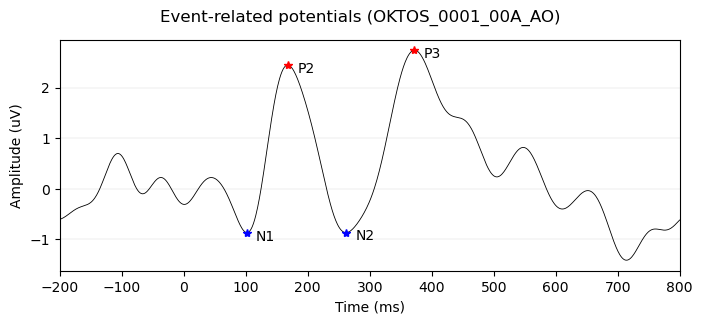

Changing time window parameters for OKTOS_0001_00A_AO
Changing P3 with new time window: [500, 600, 1]


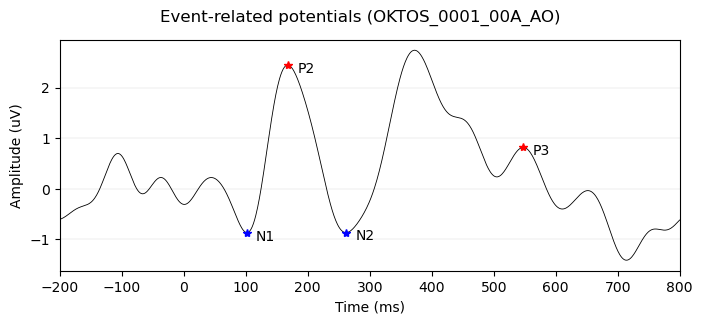

Changing time window parameters for OKTOS_0001_00A_AO
Changing P3 with new time window: [300, 400, 1]


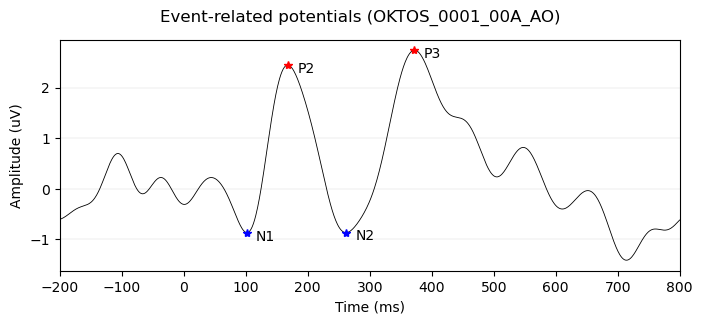

ERPs have been found and added to the dataframe for OKTOS_0001_00A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0001_00A_AO,101.5625,261.71875,167.96875,372.070312,-0.868872,-0.868437,2.448774,2.74151


Adding relative amplitudes for N1-P2, P2-N2, N2-P3


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude,N1-P2 amplitude,P2-N2 amplitude,N2-P3 amplitude
OKTOS_0001_00A_AO,101.5625,261.71875,167.96875,372.070312,-0.868872,-0.868437,2.448774,2.74151,3.317646,-3.317212,3.609948


In [8]:
# Loop through all the subjects' directories (EEG files directories)
df_erps = pd.DataFrame()
evoked_signal = [None]*len(file_dirs)

arrange.create_results_folders(exp_folder=exp_folder,results_folder=results_foldername, erps=True)

for i in range(len(file_dirs)):
    erp_wins_temp = erp_wins
    # Read the clean data from the disk
    epochs = mne.read_epochs(fname='{}/{}_clean-epo.fif'.format(dir_inprogress, subject_names[i]), verbose=False)
    
    # Create an averaged evoked object from epochs
    evoked_signal[i] = epochs[event_list].average(picks=channel_picks)

    # Find all the peaks in the evoked signal
    minpeak_times, minpeak_mags, maxpeak_times, maxpeak_mags = erpan.find_all_peaks(evoked_signal[i],
                                                                                    epochs, thresh=None,
                                                                                    subject_name=subject_names[i],
                                                                                    verbose=False, plot=False)
    
    # Identify which peaks are which ERPs based on the pre-defined ERP time windows
    erp_peaks, not_erp_peaks = erpan.identify_erps(evoked_signal[i], erp_wins_temp, minpeak_times, minpeak_mags,
                                                   maxpeak_times, maxpeak_mags, subject_name=subject_names[i],
                                                   verbose=False, plot=True, savefig=True,
                                                   results_foldername=results_foldername, exp_folder=exp_folder)

    # After visual inspection, it's possible to re-define the time windows to look for the peak
    while input('Do you need to do any manual time window changes? (leave empty if "no")') != '':
        print('Changing time window parameters for {}'.format(subject_names[i]))
        new_time_win = [None, None, None]

        # Ask user for which ERP they want to change or add
        erp_tochange = input('What ERP time window you want to change (e.g., N1)?')

        # Ask user what should be the minimum timepoint of the time window for that ERP
        new_time_win[0] = int(input('Enter MIN time of the window in interest for {} (e.g., 50)'.format(erp_tochange)))

        # Ask user what should be the maximum timepoint of the time window for that ERP
        new_time_win[1] = int(input('Enter MAX time of the window in interest for {} (e.g., 100)'.format(erp_tochange)))

        # Ask user whether this ERP should be a postitive (1) or negative (-1) peak
        new_time_win[2] = int(input('Enter whether to look for MIN (-1) or MAX (1) voltage for {}'.format(erp_tochange)))

        # Change the temporary ERP time window parameters to the user inputted parameters
        erp_wins_temp[erp_tochange] = new_time_win
        print('Changing', erp_tochange, 'with new time window:', str(new_time_win))

        # Use these new parameters to find either minimum or maximum value in that range
        try:
            erp_peaks = erpan.find_minmax_erp(evoked_signal[i], erp_peaks, erp_tochange, new_time_win,
                                              subject_name=subject_names[i], verbose=False, plot=True,
                                              savefig=True, results_foldername=results_foldername, exp_folder=exp_folder)
        except:
            print('Something went wrong with manual ERP detection, try again.')

    # Add this/these new temporary ERP to the main dataframe
    df_erps_temp = erpan.erp_dict_to_df(erp_peaks, erp_wins_temp, subject_names[i])
    df_erps = pd.concat([df_erps, df_erps_temp])
    print('ERPs have been found and added to the dataframe for {}'.format(subject_names[i]))
    display(df_erps)

# Calculate relative peak-to-peak amplitudes between the ERPs
print('Adding relative amplitudes for N1-P2, P2-N2, N2-P3')
df_erps['N1-P2 amplitude'] = df_erps['P2 amplitude'] - df_erps['N1 amplitude']
df_erps['P2-N2 amplitude'] = df_erps['N2 amplitude'] - df_erps['P2 amplitude']
df_erps['N2-P3 amplitude'] = df_erps['P3 amplitude'] - df_erps['N2 amplitude']

# Export all the detected ERPs to an Excel spreadsheet
display(df_erps)
df_erps.to_excel('{}/{}/ERP analysis/{}_{}_grandaverage_erps.xlsx'.format(results_foldername,exp_folder,exp_condition,channel_picks))